In [24]:
import pandas as pd
counts = pd.read_csv("../counts-aso.csv")
frag_miRNA = pd.read_csv("fragment-miRNA.csv")

In [25]:
## set up filter
counts = pd.read_csv('../counts-aso.csv')

# Apply filters
data_filtered = counts[(counts.iloc[:, 2:] > 100).all(axis=1)]  # Filter rows with all values > 100 in columns 2 onwards
counts = data_filtered[(data_filtered.iloc[:, 2:]< 100000).all(axis=1)]  # Further filter rows with all values < 100,000

In [26]:
len(counts)

10230

In [27]:
### Normalize the dataframe

for x in counts.columns[2:16]:
   counts[x] = counts[x]/sum(counts[x])*1000000
print(counts[0:3])

                              Seq                        Name   hek-gDNA1  \
0  ATTATTCATACTAGGGTTTGACCAACAAAG  AAGAB|ENST00000261880.10|1   77.222429   
1  TTAGTTTTTAGTAGGAGGTTAAGGAGAAAT  AAGAB|ENST00000261880.10|2   57.989275   
2  TAAATCTCAGAGGTCTGTGTGATTTACTCA  AAGAB|ENST00000261880.10|3  129.705226   

    hek-gDNA2   hek-gDNA3    hek-RNA1    hek-RNA2    hek-RNA3    sk-gDNA1  \
0   73.641523   97.547469   61.577962   61.805634   71.065166   75.686370   
1   55.429103   84.554264   61.632335   64.804522   81.768808   79.967217   
2  133.587072  147.846920  178.345002  184.902808  189.799558  170.412553   

     sk-gDNA2    sk-gDNA3    sk-RNA1    sk-RNA2    sk-RNA3    aso-lib1  \
0   65.481679   32.531802  40.149893  41.055298  47.957851   62.379810   
1   76.168337   33.321649  45.737016  46.935013  40.231831   69.823800   
2  176.285443  149.305668  84.411521  83.959240  86.564391  163.580654   

     aso-lib2  
0   60.856045  
1   66.029386  
2  158.225718  


/tmp/ipykernel_4051522/1632901369.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  counts[x] = counts[x]/sum(counts[x])*1000000


In [28]:
counts_miRNA = pd.merge(counts, frag_miRNA, on="Name")

miRNA = []
for i in counts_miRNA['miRNA']:
    miRNA.append(i.split(":")[1])   # remove the front characters(gene name) of in the column of miRNA 
counts_miRNA['miRNA'] = miRNA

print(counts_miRNA.head())

counts_miRNA.to_csv("counts_miRNA.csv",sep=',')  

                              Seq                         Name   hek-gDNA1  \
0  TTAGTTTTTAGTAGGAGGTTAAGGAGAAAT   AAGAB|ENST00000261880.10|2   57.989275   
1  TAAATCTCAGAGGTCTGTGTGATTTACTCA   AAGAB|ENST00000261880.10|3  129.705226   
2  ACTGAGTTGTGGGGGATATGTTGTATGTTA   AAGAB|ENST00000261880.10|6   92.371831   
3  TTGAGATGCCAGAGCTGTGTTGTTGCACAC   AAGAB|ENST00000261880.10|7  114.924680   
4  AACAAAGCCAGATGATTAAAATGTGATTTA  AAGAB|ENST00000261880.10|14  118.007253   

    hek-gDNA2   hek-gDNA3    hek-RNA1    hek-RNA2    hek-RNA3    sk-gDNA1  \
0   55.429103   84.554264   61.632335   64.804522   81.768808   79.967217   
1  133.587072  147.846920  178.345002  184.902808  189.799558  170.412553   
2   92.528477   98.482586   82.593310   82.712161   79.750908  111.501130   
3  117.134306  118.095434   99.095660  114.586047  107.562831  134.896456   
4  116.430444  111.894132    7.340419    6.197700    7.428211   91.167107   

     sk-gDNA2    sk-gDNA3     sk-RNA1    sk-RNA2    sk-RNA3    aso-l

In [29]:
# remove the duplicate based on "Name", and only keep the last occurrences.
counts_miRNA_1 = counts_miRNA.drop_duplicates(subset=['Name'], keep='last')
counts_miRNA_1.head()

counts_miRNA_1.to_csv("counts_miRNA_1.csv",sep=',') 

In [30]:
counts_non_miRNA=counts[~counts.Name.isin(counts_miRNA_1.Name)]
counts_non_miRNA.to_csv("counts_non_miRNA.csv",sep=',') 

In [31]:
print(counts_miRNA_1.shape)
print(counts_non_miRNA.shape)

(3538, 17)
(6692, 16)


Median non-miRNA ratio: 0.92
Median miRNA ratio: 0.74
T-statistic: 11.302, P-value: 2.338963680395043e-29


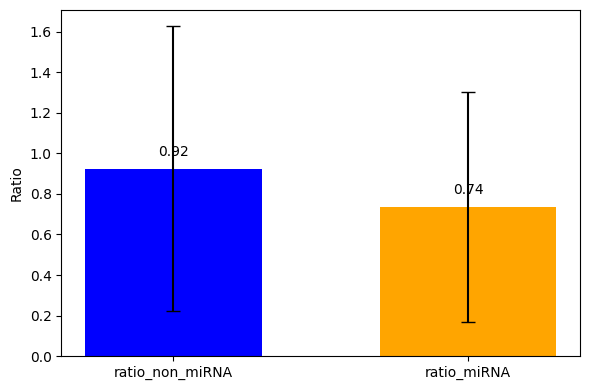

In [32]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind

# Load the data
counts_non = pd.read_csv("counts_non_miRNA.csv")
counts_miR = pd.read_csv('counts_miRNA_1.csv')

# Calculate ratios for both non-miRNA and miRNA datasets
Ratio_non = counts_non.iloc[:, 6:9].div(counts_non.iloc[:, 3:6].values)
Ratio_miR = counts_miR.iloc[:, 6:9].div(counts_miR.iloc[:, 3:6].values)

# Combine both ratios into a single DataFrame
df = pd.DataFrame({'ratio_non_miRNA': Ratio_non.mean(axis=1), 'ratio_miRNA': Ratio_miR.mean(axis=1)})

# Clean the data (remove NaN and infinite values)
df_cleaned = df.replace([np.inf, -np.inf], np.nan).dropna()

# Perform t-test
t_stat, p_value = ttest_ind(df_cleaned['ratio_non_miRNA'], df_cleaned['ratio_miRNA'], equal_var=False)

# Print results
print(f'Median non-miRNA ratio: {df_cleaned["ratio_non_miRNA"].median():.2f}')
print(f'Median miRNA ratio: {df_cleaned["ratio_miRNA"].median():.2f}')
print(f'T-statistic: {t_stat:.3f}, P-value: {p_value}')

# Plot the data
medians = df_cleaned.median()
std_devs = df_cleaned.std()

plt.figure(figsize=(6, 4))
bars = plt.bar(df_cleaned.columns, medians, yerr=std_devs, capsize=5, color=['blue', 'orange'],width=0.6)

# Annotate the bars with median values
for bar, median in zip(bars, medians):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height + 0.05, f'{median:.2f}', ha='center', va='bottom')

# Customize the plot
plt.ylabel('Ratio')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


In [33]:
counts_non = pd.read_csv("counts_non_miRNA.csv")
counts_miR = pd.read_csv('counts_miRNA_1.csv')
# print(counts_non.iloc[:,9:12])  
print(counts_miR.iloc[:,9:12])

        sk-gDNA1    sk-gDNA2    sk-gDNA3
0      79.967217   76.168337   33.321649
1     170.412553  176.285443  149.305668
2     111.501130  113.112792  102.038293
3     134.896456  135.640621  121.488262
4      91.167107   85.374848   60.916910
...          ...         ...         ...
3533   40.568491   35.434706   18.043056
3534   59.035866   49.170465   34.605149
3535   35.491208   28.152386   16.438680
3536   28.696608   27.945165   14.093823
3537   64.287370   60.863622   43.589653

[3538 rows x 3 columns]


Median non-miRNA ratio: 0.71
Median miRNA ratio: 0.56
T-statistic: 3.627, P-value: 0.0002891810549819512


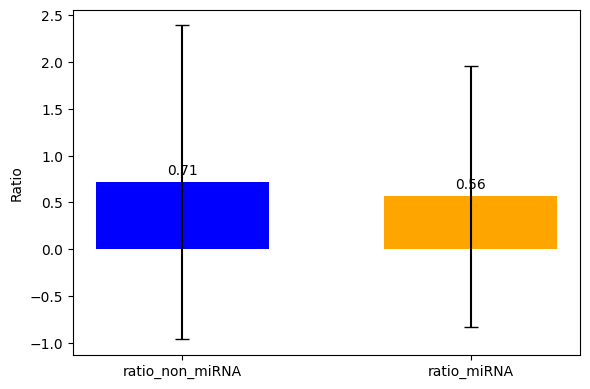

In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind

# Calculate ratios for non-miRNA and miRNA
Ratio_non = counts_non.iloc[:, 12:15].div(counts_non.iloc[:, 9:12].values)
Ratio_miR = counts_miR.iloc[:, 12:15].div(counts_miR.iloc[:, 9:12].values)

# Combine both ratios into a single DataFrame, calculate means, and clean data in one step
df = pd.DataFrame({
    'ratio_non_miRNA': Ratio_non.mean(axis=1),
    'ratio_miRNA': Ratio_miR.mean(axis=1)
}).replace([np.inf, -np.inf], np.nan).dropna()

# Perform t-test
t_stat, p_value = ttest_ind(df['ratio_non_miRNA'], df['ratio_miRNA'], equal_var=False)

# Print results
print(f'Median non-miRNA ratio: {df["ratio_non_miRNA"].median():.2f}')
print(f'Median miRNA ratio: {df["ratio_miRNA"].median():.2f}')
print(f'T-statistic: {t_stat:.3f}, P-value: {p_value}')

# Plot the data
medians = df.median()
std_devs = df.std()

plt.figure(figsize=(6, 4))
bars = plt.bar(df.columns, medians, yerr=std_devs, capsize=5, color=['blue', 'orange'],width=0.6)

# Annotate the bars with median values
for bar, median in zip(bars, medians):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height + 0.05, f'{median:.2f}', ha='center', va='bottom')

# Customize the plot
plt.ylabel('Ratio')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


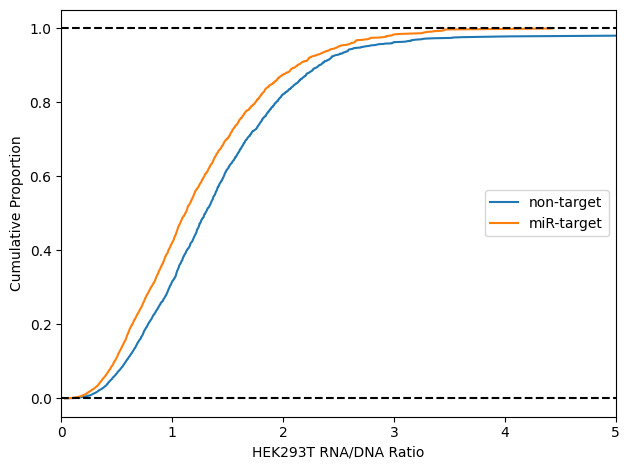

In [35]:
import numpy as np
import matplotlib.pyplot as plt

# Calculate RNA/DNA ratio for Sk cells
Ratio_non = counts_non.iloc[:, 6:9].sum(axis=1) / counts_non.iloc[:, 3:6].sum(axis=1)
Ratio_miR = counts_miR.iloc[:, 6:9].sum(axis=1) / counts_miR.iloc[:, 3:6].sum(axis=1)

# Combine the ratios into a DataFrame and clean data by removing NaN and inf values
df = pd.DataFrame({'ratio_non_miRNA': Ratio_non, 'ratio_miRNA': Ratio_miR})
df_cleaned = df.replace([np.inf, -np.inf], np.nan).dropna()

# Sort the data
sorted_non = np.sort(df_cleaned['ratio_non_miRNA'])
sorted_miR = np.sort(df_cleaned['ratio_miRNA'])

# Calculate the cumulative sum for ECDF
cumulative_non = np.cumsum(sorted_non) / np.sum(sorted_non)
cumulative_miR = np.cumsum(sorted_miR) / np.sum(sorted_miR)

# Plot the ECDF
plt.plot(sorted_non, cumulative_non, label='non-target')
plt.plot(sorted_miR, cumulative_miR, label='miR-target')

# Customize the plot
plt.xlim(0, 5)
plt.axhline(y=0, color='black', linestyle='dashed')
plt.axhline(y=1, color='black', linestyle='dashed')
plt.xlabel("HEK293T RNA/DNA Ratio")
plt.ylabel("Cumulative Proportion")
plt.legend(loc='best')
plt.tight_layout()
plt.show()

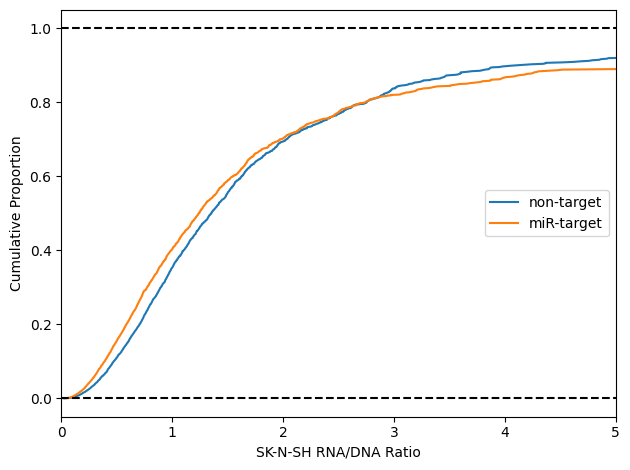

In [46]:
import numpy as np
import matplotlib.pyplot as plt

# Calculate RNA/DNA ratio for Sk cells
Ratio_non = counts_non.iloc[:, 12:15].sum(axis=1) / counts_non.iloc[:, 9:12].sum(axis=1)
Ratio_miR = counts_miR.iloc[:, 12:15].sum(axis=1) / counts_miR.iloc[:, 9:12].sum(axis=1)

# Combine the ratios into a DataFrame and clean data by removing NaN and inf values
df = pd.DataFrame({'ratio_non_miRNA': Ratio_non, 'ratio_miRNA': Ratio_miR})
df_cleaned = df.replace([np.inf, -np.inf], np.nan).dropna()

# Sort the data
sorted_non = np.sort(df_cleaned['ratio_non_miRNA'])
sorted_miR = np.sort(df_cleaned['ratio_miRNA'])

# Calculate the cumulative sum for ECDF
cumulative_non = np.cumsum(sorted_non) / np.sum(sorted_non)
cumulative_miR = np.cumsum(sorted_miR) / np.sum(sorted_miR)

# Plot the ECDF
plt.plot(sorted_non, cumulative_non, label='non-target')
plt.plot(sorted_miR, cumulative_miR, label='miR-target')

# Customize the plot
plt.xlim(0, 5)
plt.axhline(y=0, color='black', linestyle='dashed')
plt.axhline(y=1, color='black', linestyle='dashed')
plt.xlabel("SK-N-SH RNA/DNA Ratio")
plt.ylabel("Cumulative Proportion")
plt.legend(loc='best')
plt.tight_layout()
plt.show()

Total unique miRNAs: 209
miR-377-3p: Statistic=-0.31, -log(p-value)=12.80
miR-23-3p: Statistic=-0.25, -log(p-value)=17.87
miR-655-3p: Statistic=-0.28, -log(p-value)=14.39
miR-200bc-3p/429: Statistic=-0.17, -log(p-value)=7.13
miR-30-5p: Statistic=-0.24, -log(p-value)=14.88
miR-96-5p/1271-5p: Statistic=-0.14, -log(p-value)=3.79
miR-183-5p.2: Statistic=-0.16, -log(p-value)=4.13
miR-9-5p: Statistic=-0.22, -log(p-value)=14.04
miR-145-5p: Statistic=-0.15, -log(p-value)=3.32
miR-204-5p/211-5p: Statistic=-0.18, -log(p-value)=5.34
miR-101-3p.2: Statistic=-0.21, -log(p-value)=13.23
miR-130-3p/301-3p/454-3p: Statistic=-0.28, -log(p-value)=16.37
miR-144-3p: Statistic=-0.17, -log(p-value)=7.44
miR-17-5p/20-5p/93-5p/106-5p/519-3p: Statistic=-0.13, -log(p-value)=3.97
miR-19-3p: Statistic=-0.22, -log(p-value)=13.60
miR-15-5p/16-5p/195-5p/424-5p/497-5p: Statistic=-0.14, -log(p-value)=5.41
miR-137: Statistic=-0.34, -log(p-value)=25.93
miR-505-3p.1: Statistic=-0.29, -log(p-value)=3.44
miR-29-3p: Statisti

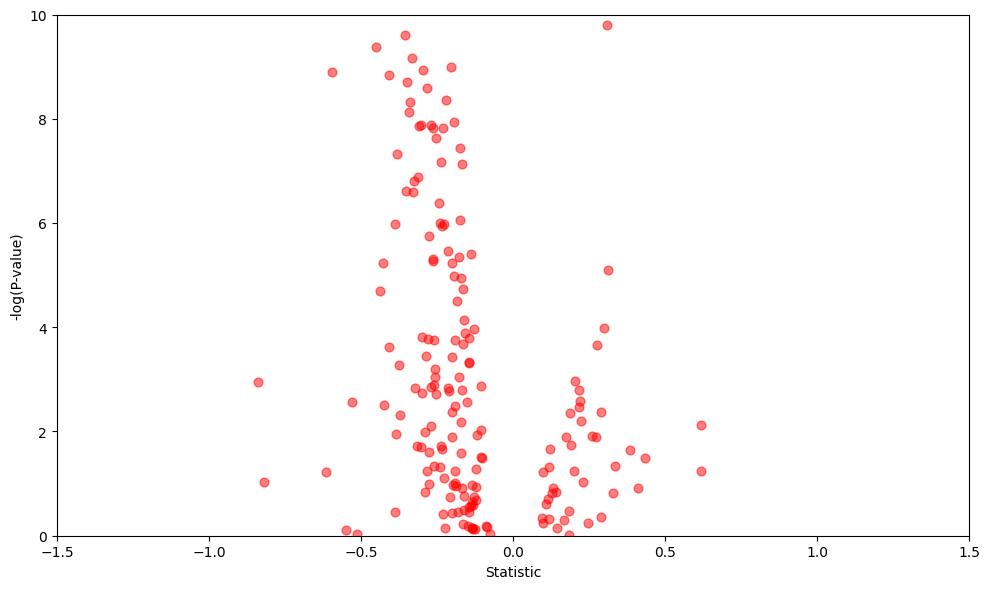

In [37]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import ks_2samp

# Load data
counts_non = pd.read_csv("counts_non_miRNA.csv")
counts_miR = pd.read_csv('counts_miRNA.csv')

# Calculate ratios for HEK293T cell
Ratio_non = (counts_non.iloc[:, 12:15].mean(axis=1)) / (counts_non.iloc[:, 9:12].mean(axis=1))

# Get unique miRNA
miRNAs = counts_miR['miRNA'].unique()
print(f"Total unique miRNAs: {len(miRNAs)}")

# Initialize lists to store results
pvalues = []
statistics = []
valid_results = 0

# Loop over each unique miRNA
for miRNA in miRNAs:
    # Get data for the current miRNA
    miR_data = counts_miR[counts_miR["miRNA"] == miRNA]
    
    # Calculate ratios for miRNA
    ls_miR = (miR_data.iloc[:, 12:15].mean(axis=1)) / (miR_data.iloc[:, 9:12].mean(axis=1)).tolist()

    # Check if the calculated ratios are valid
    if len(ls_miR) == 0 or np.isnan(np.mean(ls_miR)) or np.isnan(np.mean(Ratio_non)):
        continue  # Skip invalid ratios
    
    # Perform Kolmogorov-Smirnov test
    ks_stat, p_val = ks_2samp(Ratio_non, ls_miR)
    
    # Check if the test returned valid values
    if np.isnan(ks_stat) or np.isnan(p_val):
        continue  # Skip invalid results

    # Log-transform p-values and decide direction based on averages
    if np.mean(Ratio_non) > np.mean(ls_miR):
        statistics.append(-ks_stat)
    else:
        statistics.append(ks_stat)
    
    pvalues.append(p_val)

    # Print results if p-value < 0.05
    if p_val < 0.05:
        print(f"{miRNA}: Statistic={statistics[-1]:.2f}, -log(p-value)={-np.log(pvalues[-1]):.2f}")
        valid_results += 1

# If no valid results, print a message
if valid_results == 0:
    print("No results with p-value < 0.05 found.")
else:
    # Create a scatter plot
    plt.figure(figsize=(10, 6))  # Increased plot size
    plt.scatter(statistics, -np.log(pvalues), s=40, c='red', alpha=0.5)  # Increased marker size
    plt.xlabel('Statistic')
    plt.ylabel('-log(P-value)')
    plt.xlim(-1.5, 1.5)
    plt.ylim(0, 10)  # Adjust y-limit to avoid too large -log(p-value) values
    plt.tight_layout()
    plt.show()

# Analyze miR7 and mir124 targeting effects

In [55]:
import pandas as pd


# Load data 
df = pd.read_csv('fragment-miRNA.csv')

# Filter the rows with miR-7-5p and miR-124-3p

df_miR7 = df[df['miRNA'].str.contains('miR-7-5p')]
df_miR124 = df[df['miRNA'].str.contains('miR-124')]

print(df_miR7.head(),len(df_miR7))
print(df_miR124.head(),len(df_miR124))



                           Name           miRNA
209   AKT3|ENST00000673466.1|28   AKT3:miR-7-5p
210   AKT3|ENST00000673466.1|29   AKT3:miR-7-5p
460  ARID2|ENST00000334344.11|8  ARID2:miR-7-5p
469  ARID2|ENST00000334344.11|9  ARID2:miR-7-5p
498  ASXL1|ENST00000375687.10|2  ASXL1:miR-7-5p 68
                          Name                     miRNA
18   ABCD1|ENST00000218104.6|6        ABCD1:miR-124-3p.1
25   ABCD1|ENST00000218104.6|7        ABCD1:miR-124-3p.1
55    ACTB|ENST00000646664.1|3  ACTB:miR-124-3p.2/506-3p
57    ACTB|ENST00000646664.1|4  ACTB:miR-124-3p.2/506-3p
219  AKT3|ENST00000673466.1|37         AKT3:miR-124-3p.1 334


In [56]:
# merge filtered df with original counts
import pandas as pd

counts = pd.read_csv('../counts-aso.csv')

# Apply filters
data_filtered = counts[(counts.iloc[:, 2:] > 100).all(axis=1)]  # Filter rows with all values > 100 in columns 2 onwards
counts = data_filtered[(data_filtered.iloc[:, 2:]< 100000).all(axis=1)]  # Further filter rows with all values < 100,000

### Normalize the dataframe

for x in counts.columns[2:16]:
   counts[x] = counts[x]/sum(counts[x])*1000000
print(counts[0:3])

                              Seq                        Name   hek-gDNA1  \
0  ATTATTCATACTAGGGTTTGACCAACAAAG  AAGAB|ENST00000261880.10|1   77.222429   
1  TTAGTTTTTAGTAGGAGGTTAAGGAGAAAT  AAGAB|ENST00000261880.10|2   57.989275   
2  TAAATCTCAGAGGTCTGTGTGATTTACTCA  AAGAB|ENST00000261880.10|3  129.705226   

    hek-gDNA2   hek-gDNA3    hek-RNA1    hek-RNA2    hek-RNA3    sk-gDNA1  \
0   73.641523   97.547469   61.577962   61.805634   71.065166   75.686370   
1   55.429103   84.554264   61.632335   64.804522   81.768808   79.967217   
2  133.587072  147.846920  178.345002  184.902808  189.799558  170.412553   

     sk-gDNA2    sk-gDNA3    sk-RNA1    sk-RNA2    sk-RNA3    aso-lib1  \
0   65.481679   32.531802  40.149893  41.055298  47.957851   62.379810   
1   76.168337   33.321649  45.737016  46.935013  40.231831   69.823800   
2  176.285443  149.305668  84.411521  83.959240  86.564391  163.580654   

     aso-lib2  
0   60.856045  
1   66.029386  
2  158.225718  


/tmp/ipykernel_4051522/2597481681.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  counts[x] = counts[x]/sum(counts[x])*1000000


In [57]:


df_w_miR7 = pd.merge(left=counts,right=df_miR7, on='Name', how='inner')
df_w_miR124 = pd.merge(left=counts,right=df_miR124, on='Name', how='inner')

print(len(df_w_miR7), df_w_miR7.head())

61                               Seq                        Name   hek-gDNA1  \
0  ACACATAGGGGATCATTTTTACTTCAGTGA   AKT3|ENST00000673466.1|28  214.647264   
1  ATGAAGGAGGTCTCAGACCCTGGGGACATT   AKT3|ENST00000673466.1|29  146.251008   
2  ATGTCATTTTTTAGAAGAAAAACTATTTGA  ARID2|ENST00000334344.11|8   40.600397   
3  ATGGAATTTTATACAGGTTTTCTCCTGTGT  ARID2|ENST00000334344.11|9  125.832249   
4  ACTGCTAAAGCCCTCTGTCACTTGGCGACC  ASXL1|ENST00000375687.10|2  171.464882   

    hek-gDNA2   hek-gDNA3    hek-RNA1    hek-RNA2    hek-RNA3    sk-gDNA1  \
0  214.032590  200.434948  325.778683  367.892041  345.733493  220.388952   
1  143.734410  142.482302  177.257532  213.035225  205.065408  159.113108   
2   39.709527   50.767010   48.365207   42.127223   48.575819   25.784636   
3  120.653614   88.516207  317.459541  318.196199  363.251203  116.976632   
4  167.929653  165.737185  220.430072  212.435448  214.394539  200.702034   

     sk-gDNA2    sk-gDNA3     sk-RNA1      sk-RNA2     sk-RNA3    aso-l

In [58]:
# Extract the different part of two df
df = pd.merge(left=counts,right=df_miR7, how='left', indicator=True, on='Name')
df_wo_miR7 = df.loc[df._merge == 'left_only', :].drop(columns='_merge')
print(len(df_wo_miR7))

df = pd.merge(left=counts,right=df_miR124, how='left', indicator=True, on='Name')
df_wo_miR124 = df.loc[df._merge == 'left_only', :].drop(columns='_merge')
print(len(df_wo_miR124))

10169
10032


In [59]:
# Calculate rna to dna ratio

# with miR7-target gene
df_w_miR7['hek_rd'] = df_w_miR7.iloc[:, [5, 6, 7]].mean(axis=1) / df_w_miR7.iloc[:, [2, 3, 4]].mean(axis=1)
df_w_miR7['sk_rd'] = df_w_miR7.iloc[:, [11, 12, 13]].mean(axis=1) / df_w_miR7.iloc[:, [8, 9, 10]].mean(axis=1)

# without miR7-target gene
df_wo_miR7['hek_rd'] = df_wo_miR7.iloc[:, [5, 6, 7]].mean(axis=1) / df_wo_miR7.iloc[:, [2, 3, 4]].mean(axis=1)
df_wo_miR7['sk_rd'] = df_wo_miR7.iloc[:, [11, 12, 13]].mean(axis=1) / df_wo_miR7.iloc[:, [8, 9, 10]].mean(axis=1)


#print(df_w_miR7.iloc[:,[8,9,10]])

print(df_w_miR7.head())


                              Seq                        Name   hek-gDNA1  \
0  ACACATAGGGGATCATTTTTACTTCAGTGA   AKT3|ENST00000673466.1|28  214.647264   
1  ATGAAGGAGGTCTCAGACCCTGGGGACATT   AKT3|ENST00000673466.1|29  146.251008   
2  ATGTCATTTTTTAGAAGAAAAACTATTTGA  ARID2|ENST00000334344.11|8   40.600397   
3  ATGGAATTTTATACAGGTTTTCTCCTGTGT  ARID2|ENST00000334344.11|9  125.832249   
4  ACTGCTAAAGCCCTCTGTCACTTGGCGACC  ASXL1|ENST00000375687.10|2  171.464882   

    hek-gDNA2   hek-gDNA3    hek-RNA1    hek-RNA2    hek-RNA3    sk-gDNA1  \
0  214.032590  200.434948  325.778683  367.892041  345.733493  220.388952   
1  143.734410  142.482302  177.257532  213.035225  205.065408  159.113108   
2   39.709527   50.767010   48.365207   42.127223   48.575819   25.784636   
3  120.653614   88.516207  317.459541  318.196199  363.251203  116.976632   
4  167.929653  165.737185  220.430072  212.435448  214.394539  200.702034   

     sk-gDNA2    sk-gDNA3     sk-RNA1      sk-RNA2     sk-RNA3    aso-lib1

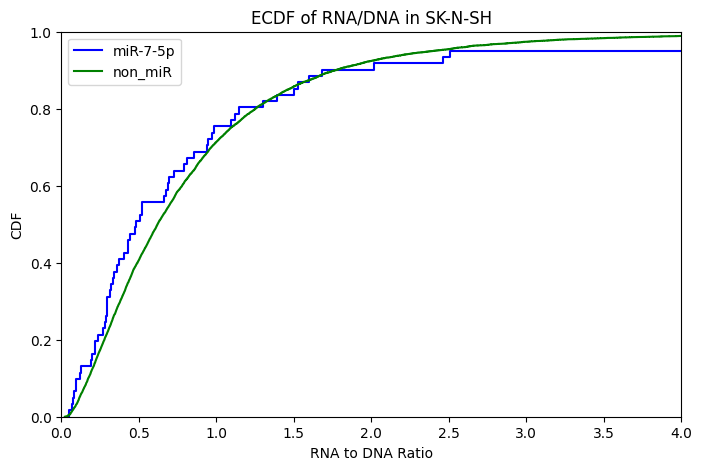

In [60]:
# draw ecdf plot

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Plotting ECDF
plt.figure(figsize=(8, 5))

# Empirical Cumulative Distribution Function plot
sns.ecdfplot(df_w_miR7['sk_rd'], label='miR-7-5p', linestyle='-', color='blue')
sns.ecdfplot(df_wo_miR7['sk_rd'], label='non_miR', linestyle='-', color='green')

plt.xlim(0, 4)
plt.xlabel('RNA to DNA Ratio')
plt.ylabel('CDF')
plt.grid(False)
plt.legend()
plt.title('ECDF of RNA/DNA in SK-N-SH')
plt.show()

In [62]:
# Replace infinite values by NaN
df_w_miR7['sk_rd'].replace([np.inf, -np.inf], np.nan, inplace=True)
df_wo_miR7['sk_rd'].replace([np.inf, -np.inf], np.nan, inplace=True)

# Remove NaN values
# Drop NaNs introduced by infinity replacement or present otherwise
df_w_miR7.dropna(subset=['sk_rd'], inplace=True)
df_wo_miR7.dropna(subset=['sk_rd'], inplace=True)

# Recompute standard deviations
std_w_miR7 = df_w_miR7['sk_rd'].std()
std_wo_miR7 = df_wo_miR7['sk_rd'].std()

# Perform the t-test if both standard deviations are non-zero
if std_w_miR7 != 0 and std_wo_miR7 != 0:
    t_stat, p_value = ttest_ind(df_w_miR7['sk_rd'], df_wo_miR7['sk_rd'], equal_var=False, nan_policy='omit')
    print("T-statistic:", t_stat)
    print("P-value:", p_value)
else:
    print("Cannot perform t-test due to zero standard deviation in one of the groups.")


T-statistic: 0.18206940052262494
P-value: 0.8561345128374054


/tmp/ipykernel_4051522/3765925184.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_w_miR7['sk_rd'].replace([np.inf, -np.inf], np.nan, inplace=True)
/tmp/ipykernel_4051522/3765925184.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(va

                              Seq                       Name   hek-gDNA1  \
0  ATGTGACTACCGTGCCAGCAGCGGGGGCGG  ABCD1|ENST00000218104.6|6   50.533135   
1  ACCCAGCCCCTGCGGCCGTCACCCCGCCAG  ABCD1|ENST00000218104.6|7  110.234952   
2  TTACAGGAAGTCCCTTGCCATCCTAAAAGC   ACTB|ENST00000646664.1|3  120.035956   
3  AGTCCTCTCCCAAGTCCACACAGGGGAGGT   ACTB|ENST00000646664.1|4   63.838262   
4  AGACTTCACGGGCAATCATGAGCAAGTGAA   AKT3|ENST00000673466.1|6   91.555081   

    hek-gDNA2   hek-gDNA3    hek-RNA1    hek-RNA2    hek-RNA3    sk-gDNA1  \
0   48.478470   49.167468  167.551867  144.889087  133.532324   65.531803   
1  109.098552   98.827102  179.269351  159.540792  154.939608  123.796121   
2  117.016996  117.554051   79.113408   74.915055   81.008440  107.718056   
3   66.309631   63.932473   24.359317   22.277447   24.302532   49.901733   
4   92.499149   90.337224   95.670131   94.936196   91.565857   85.741382   

     sk-gDNA2    sk-gDNA3     sk-RNA1     sk-RNA2     sk-RNA3    aso-lib1  \
0  

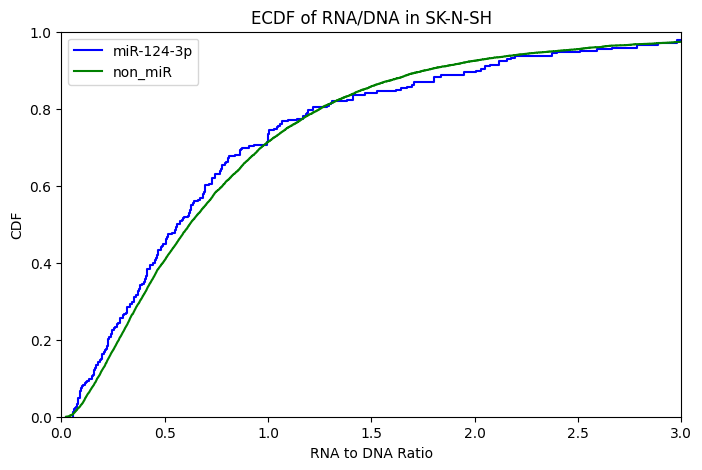

In [63]:
# compare miR-124 target vs non-target
# Calculate rna to dna ratio

# with miR124-target gene
df_wo_miR124['sk_rd'] = df_wo_miR124.iloc[:, [11, 12, 13]].mean(axis=1) / df_wo_miR124.iloc[:, [8, 9, 10]].mean(axis=1)
df_w_miR124['sk_rd'] = df_w_miR124.iloc[:, [11, 12, 13]].mean(axis=1) / df_w_miR124.iloc[:, [8, 9, 10]].mean(axis=1)

#print(df_w_miR7.iloc[:,[8,9,10]])

print(df_w_miR124.head())

# draw ecdf plot

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Plotting ECDF
plt.figure(figsize=(8, 5))

# Empirical Cumulative Distribution Function plot
sns.ecdfplot(df_w_miR124['sk_rd'], label='miR-124-3p', linestyle='-', color='blue')
sns.ecdfplot(df_wo_miR124['sk_rd'], label='non_miR', linestyle='-', color='green')

plt.xlim(0,3)
plt.xlabel('RNA to DNA Ratio')
plt.ylabel('CDF')
plt.grid(False)
plt.legend()
plt.title('ECDF of RNA/DNA in SK-N-SH')
plt.show()

In [64]:
# t-test
# Replace infinite values by NaN
from scipy.stats import ttest_ind
import numpy as np

df_w_miR124['sk_rd'].replace([np.inf, -np.inf], np.nan, inplace=True)
df_wo_miR124['sk_rd'].replace([np.inf, -np.inf], np.nan, inplace=True)

# Remove NaN values
# Drop NaNs introduced by infinity replacement or present otherwise
df_w_miR124.dropna(subset=['sk_rd'], inplace=True)
df_wo_miR124.dropna(subset=['sk_rd'], inplace=True)

# Recompute standard deviations
std_w_miR124 = df_w_miR124['sk_rd'].std()
std_wo_miR124 = df_wo_miR124['sk_rd'].std()

# Perform the t-test if both standard deviations are non-zero
if std_w_miR124 != 0 and std_wo_miR124 != 0:
    t_stat, p_value = ttest_ind(df_w_miR124['sk_rd'], df_wo_miR124['sk_rd'], equal_var=False, nan_policy='omit')
    print("T-statistic:", t_stat)
    print("P-value:", p_value)
else:
    print("Cannot perform t-test due to zero standard deviation in one of the groups.")


T-statistic: -0.12241901297897649
P-value: 0.9026555869533289


/tmp/ipykernel_4051522/3964587782.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_w_miR124['sk_rd'].replace([np.inf, -np.inf], np.nan, inplace=True)
/tmp/ipykernel_4051522/3964587782.py:7: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(

                              Seq                       Name   hek-gDNA1  \
0  ATGTGACTACCGTGCCAGCAGCGGGGGCGG  ABCD1|ENST00000218104.6|6   50.533135   
1  ACCCAGCCCCTGCGGCCGTCACCCCGCCAG  ABCD1|ENST00000218104.6|7  110.234952   
2  TTACAGGAAGTCCCTTGCCATCCTAAAAGC   ACTB|ENST00000646664.1|3  120.035956   
3  AGTCCTCTCCCAAGTCCACACAGGGGAGGT   ACTB|ENST00000646664.1|4   63.838262   
4  AGACTTCACGGGCAATCATGAGCAAGTGAA   AKT3|ENST00000673466.1|6   91.555081   

    hek-gDNA2   hek-gDNA3    hek-RNA1    hek-RNA2    hek-RNA3    sk-gDNA1  \
0   48.478470   49.167468  167.551867  144.889087  133.532324   65.531803   
1  109.098552   98.827102  179.269351  159.540792  154.939608  123.796121   
2  117.016996  117.554051   79.113408   74.915055   81.008440  107.718056   
3   66.309631   63.932473   24.359317   22.277447   24.302532   49.901733   
4   92.499149   90.337224   95.670131   94.936196   91.565857   85.741382   

     sk-gDNA2    sk-gDNA3     sk-RNA1     sk-RNA2     sk-RNA3    aso-lib1  \
0  

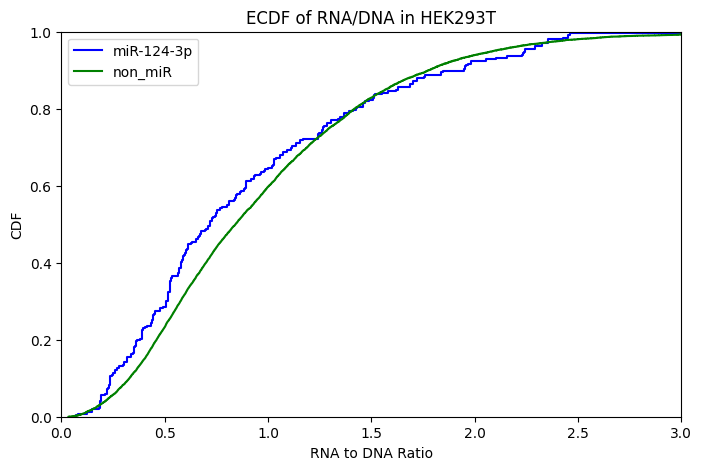

In [65]:
# Based on hek_rd ratio

# compare miR-124 target vs non-target
# Calculate rna to dna ratio

# with miR7-target gene
df_w_miR124['hek_rd'] = df_w_miR124.iloc[:, [5, 6, 7]].mean(axis=1) / df_w_miR124.iloc[:, [2, 3, 4]].mean(axis=1)
df_wo_miR124['hek_rd'] = df_wo_miR124.iloc[:, [5, 6, 7]].mean(axis=1) / df_wo_miR124.iloc[:, [2, 3, 4]].mean(axis=1)


#print(df_w_miR7.iloc[:,[8,9,10]])

print(df_w_miR124.head())

# draw ecdf plot

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Plotting ECDF
plt.figure(figsize=(8, 5))

# Empirical Cumulative Distribution Function plot
sns.ecdfplot(df_w_miR124['hek_rd'], label='miR-124-3p', linestyle='-', color='blue')
sns.ecdfplot(df_wo_miR124['hek_rd'], label='non_miR', linestyle='-', color='green')

plt.xlim(0,3)
plt.xlabel('RNA to DNA Ratio')
plt.ylabel('CDF')
plt.grid(False)
plt.legend()
plt.title('ECDF of RNA/DNA in HEK293T')
plt.show()


In [66]:
# t-test  hek_miRNA-124 vs non-miR-124
# Replace infinite values by NaN
df_w_miR124['hek_rd'].replace([np.inf, -np.inf], np.nan, inplace=True)
df_wo_miR124['hek_rd'].replace([np.inf, -np.inf], np.nan, inplace=True)

# Remove NaN values
# Drop NaNs introduced by infinity replacement or present otherwise
df_w_miR124.dropna(subset=['hek_rd'], inplace=True)
df_wo_miR124.dropna(subset=['hek_rd'], inplace=True)

# Recompute standard deviations
std_w_miR124 = df_w_miR124['hek_rd'].std()
std_wo_miR124 = df_wo_miR124['hek_rd'].std()

# Perform the t-test if both standard deviations are non-zero
if std_w_miR124 != 0 and std_wo_miR124 != 0:
    t_stat, p_value = ttest_ind(df_w_miR124['hek_rd'], df_wo_miR124['hek_rd'], equal_var=False, nan_policy='omit')
    print("T-statistic:", t_stat)
    print("P-value:", p_value)
else:
    print("Cannot perform t-test due to zero standard deviation in one of the groups.")


T-statistic: -1.686605711236869
P-value: 0.09279378290791632


/tmp/ipykernel_4051522/786862255.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_w_miR124['hek_rd'].replace([np.inf, -np.inf], np.nan, inplace=True)
/tmp/ipykernel_4051522/786862255.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(v

                              Seq                        Name   hek-gDNA1  \
0  ACACATAGGGGATCATTTTTACTTCAGTGA   AKT3|ENST00000673466.1|28  214.647264   
1  ATGAAGGAGGTCTCAGACCCTGGGGACATT   AKT3|ENST00000673466.1|29  146.251008   
2  ATGTCATTTTTTAGAAGAAAAACTATTTGA  ARID2|ENST00000334344.11|8   40.600397   
3  ATGGAATTTTATACAGGTTTTCTCCTGTGT  ARID2|ENST00000334344.11|9  125.832249   
4  ACTGCTAAAGCCCTCTGTCACTTGGCGACC  ASXL1|ENST00000375687.10|2  171.464882   

    hek-gDNA2   hek-gDNA3    hek-RNA1    hek-RNA2    hek-RNA3    sk-gDNA1  \
0  214.032590  200.434948  325.778683  367.892041  345.733493  220.388952   
1  143.734410  142.482302  177.257532  213.035225  205.065408  159.113108   
2   39.709527   50.767010   48.365207   42.127223   48.575819   25.784636   
3  120.653614   88.516207  317.459541  318.196199  363.251203  116.976632   
4  167.929653  165.737185  220.430072  212.435448  214.394539  200.702034   

     sk-gDNA2    sk-gDNA3     sk-RNA1      sk-RNA2     sk-RNA3    aso-lib1

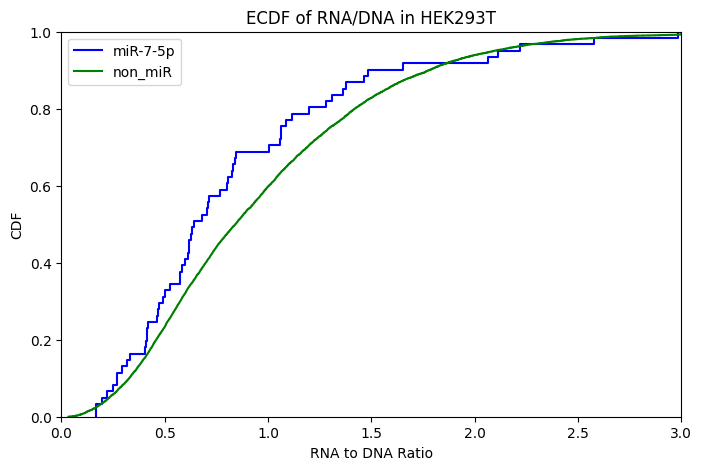

In [67]:
# HEK293t miR-7-5p taget vs non target

# with miR7-target gene
df_w_miR7['hek_rd'] = df_w_miR7.iloc[:, [5, 6, 7]].mean(axis=1) / df_w_miR7.iloc[:, [2, 3, 4]].mean(axis=1)
df_w_miR7['sk_rd'] = df_w_miR7.iloc[:, [11, 12, 13]].mean(axis=1) / df_w_miR7.iloc[:, [8, 9, 10]].mean(axis=1)

# without miR7-target gene
df_wo_miR7['hek_rd'] = df_wo_miR7.iloc[:, [5, 6, 7]].mean(axis=1) / df_wo_miR7.iloc[:, [2, 3, 4]].mean(axis=1)
df_wo_miR7['sk_rd'] = df_wo_miR7.iloc[:, [11, 12, 13]].mean(axis=1) / df_wo_miR7.iloc[:, [8, 9, 10]].mean(axis=1)


#print(df_w_miR7.iloc[:,[8,9,10]])

print(df_w_miR7.head())

# draw ecdf plot

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Plotting ECDF
plt.figure(figsize=(8, 5))

# Empirical Cumulative Distribution Function plot
sns.ecdfplot(df_w_miR7['hek_rd'], label='miR-7-5p', linestyle='-', color='blue')
sns.ecdfplot(df_wo_miR7['hek_rd'], label='non_miR', linestyle='-', color='green')

plt.xlim(0,3)
plt.xlabel('RNA to DNA Ratio')
plt.ylabel('CDF')
plt.grid(False)
plt.legend()
plt.title('ECDF of RNA/DNA in HEK293T')
plt.show()


In [68]:
# t-test  hek_miRNA-124 vs non-miR-124
# Replace infinite values by NaN
df_w_miR7['hek_rd'].replace([np.inf, -np.inf], np.nan, inplace=True)
df_wo_miR7['hek_rd'].replace([np.inf, -np.inf], np.nan, inplace=True)

# Remove NaN values
# Drop NaNs introduced by infinity replacement or present otherwise
df_w_miR7.dropna(subset=['hek_rd'], inplace=True)
df_wo_miR7.dropna(subset=['hek_rd'], inplace=True)

# Recompute standard deviations
std_w_miR7 = df_w_miR7['hek_rd'].std()
std_wo_miR7 = df_wo_miR7['hek_rd'].std()

# Perform the t-test if both standard deviations are non-zero
if std_w_miR7 != 0 and std_wo_miR7 != 0:
    t_stat, p_value = ttest_ind(df_w_miR7['hek_rd'], df_wo_miR7['hek_rd'], equal_var=False, nan_policy='omit')
    print("T-statistic:", t_stat)
    print("P-value:", p_value)
else:
    print("Cannot perform t-test due to zero standard deviation in one of the groups.")


T-statistic: -1.6328375099434926
P-value: 0.10767117360523006


/tmp/ipykernel_4051522/2401206954.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_w_miR7['hek_rd'].replace([np.inf, -np.inf], np.nan, inplace=True)
/tmp/ipykernel_4051522/2401206954.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(v

# Each miRNA target site with a mut-site, compare the target and mutant

In [69]:
import pandas as pd

# Load data 
df = pd.read_csv('fragment-miRNA.csv')

# Filter the rows with miR-7-5p and miR-124-3p

df_miR7 = df[df['miRNA'].str.contains('miR-7-5p')]
df_miR124 = df[df['miRNA'].str.contains('miR-124')]

print(len(df_miR7['Name']))
print(df_miR124.head(),len(df_miR124))

68
                          Name                     miRNA
18   ABCD1|ENST00000218104.6|6        ABCD1:miR-124-3p.1
25   ABCD1|ENST00000218104.6|7        ABCD1:miR-124-3p.1
55    ACTB|ENST00000646664.1|3  ACTB:miR-124-3p.2/506-3p
57    ACTB|ENST00000646664.1|4  ACTB:miR-124-3p.2/506-3p
219  AKT3|ENST00000673466.1|37         AKT3:miR-124-3p.1 334


In [70]:
import pandas as pd
from difflib import get_close_matches

non = pd.read_csv('counts_non_miRNA.csv')

def find_closest_match(name, search_list, cutoff=0.5):
    """ Find the closest match in the search_list for the given name. """
    matches = get_close_matches(name, search_list, n=1, cutoff=cutoff)
    return matches[0] if matches else None

# Create a MergeKey in df_miR7 based on closest matches in non
search_list = non['Name'].tolist()
df_miR7['MergeKey'] = df_miR7['Name'].apply(lambda x: find_closest_match(x, search_list))

# Merge based on the new key
result = pd.merge(non, df_miR7, left_on='Name',right_on='MergeKey')
result.drop(columns=['MergeKey'], inplace=True)

#print(result)
print(len(result))

68


/tmp/ipykernel_4051522/4190350014.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_miR7['MergeKey'] = df_miR7['Name'].apply(lambda x: find_closest_match(x, search_list))


In [71]:
result['hek_rd'] = (result.iloc[:,6:9].mean(axis=1)/result.iloc[:,3:6].mean(axis=1))
result['sk_rd'] = (result.iloc[:,12:15].mean(axis=1))/(result.iloc[:,9:12].mean(axis=1))

print(result.head())


   Unnamed: 0                             Seq                       Name_x  \
0         266  GTGGTTCTATAATCCCCCCAAATTAAATCT    AKT3|ENST00000673466.1|27   
1         266  GTGGTTCTATAATCCCCCCAAATTAAATCT    AKT3|ENST00000673466.1|27   
2         497  TGGTGTCCTAGAAGCATTATTGGTAGGTTC   ARID2|ENST00000334344.11|6   
3         509  GCAGGTTTAGAAAAATGGTTTTCATATTCA  ARID2|ENST00000334344.11|18   
4         529  TCATGTATTTATATGTTGTACACAGTACTG   ASXL1|ENST00000375687.10|8   

    hek-gDNA1   hek-gDNA2   hek-gDNA3    hek-RNA1    hek-RNA2    hek-RNA3  \
0   68.027401   69.858267   74.071110   23.054354   27.304153   32.140172   
1   68.027401   69.858267   74.071110   23.054354   27.304153   32.140172   
2  109.102040  107.984105  108.719656   41.269468   24.819361   33.309969   
3   89.579072   85.753808   96.956868   66.308454   66.632415   62.818097   
4  123.856240  120.418994  142.359260  163.664163  145.574547  141.019024   

     sk-gDNA1  ...    sk-gDNA3    sk-RNA1    sk-RNA2    sk-RNA3    a

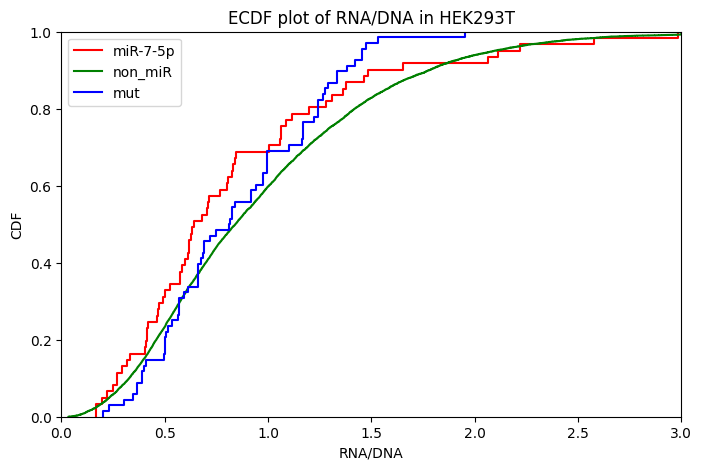

In [72]:
# HEK293t miR-7-5p taget vs non target vs all the left non-target

# draw ecdf plot

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Plotting ECDF
plt.figure(figsize=(8, 5))

# Empirical Cumulative Distribution Function plot
sns.ecdfplot(df_w_miR7['hek_rd'], label='miR-7-5p', linestyle='-', color='red')
sns.ecdfplot(df_wo_miR7['hek_rd'], label='non_miR', linestyle='-', color='green')
sns.ecdfplot(result['hek_rd'], label='mut', linestyle='-', color='blue')

plt.xlim(0,3)
plt.title('ECDF plot of RNA/DNA in HEK293T')
plt.xlabel('RNA/DNA')
plt.ylabel('CDF')
plt.grid(False)
plt.legend()
plt.show()

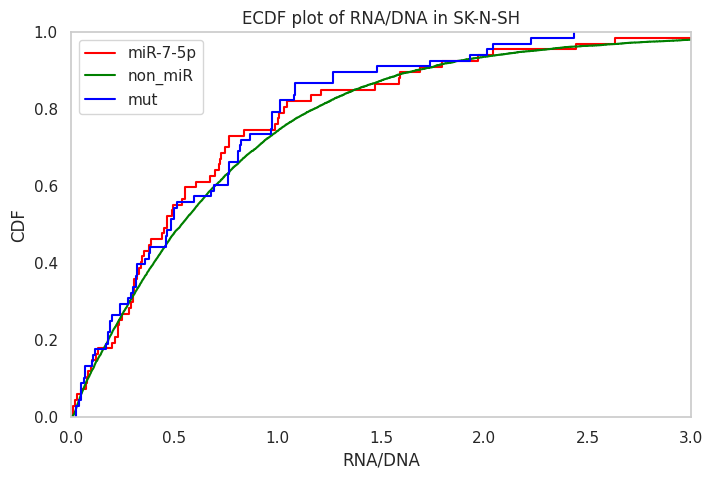

In [72]:
# SK miR-7-5p taget vs non target vs all the left non-target

# draw ecdf plot

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Plotting ECDF
plt.figure(figsize=(8, 5))

# Empirical Cumulative Distribution Function plot
sns.ecdfplot(df_w_miR7['sk_rd'], label='miR-7-5p', linestyle='-', color='red')
sns.ecdfplot(df_wo_miR7['sk_rd'], label='non_miR', linestyle='-', color='green')
sns.ecdfplot(result['sk_rd'], label='mut', linestyle='-', color='blue')

plt.xlim(0,3)
plt.title('ECDF plot of RNA/DNA in SK-N-SH')
plt.xlabel('RNA/DNA')
plt.ylabel('CDF')
plt.grid(False)
plt.legend()
plt.show()

In [73]:
# miR124

import pandas as pd
from difflib import get_close_matches

non = pd.read_csv('counts_non_miRNA.csv')

def find_closest_match(name, search_list, cutoff=0.5):
    """ Find the closest match in the search_list for the given name. """
    matches = get_close_matches(name, search_list, n=1, cutoff=cutoff)
    return matches[0] if matches else None

# Create a MergeKey in df_miR7 based on closest matches in non
search_list = non['Name'].tolist()
df_miR124['MergeKey'] = df_miR124['Name'].apply(lambda x: find_closest_match(x, search_list))

# Merge based on the new key
result = pd.merge(non, df_miR124, left_on='Name',right_on='MergeKey')
result.drop(columns=['MergeKey'], inplace=True)

#print(result)
print(len(result))

334


/tmp/ipykernel_4051522/3605798309.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_miR124['MergeKey'] = df_miR124['Name'].apply(lambda x: find_closest_match(x, search_list))


In [74]:
result['hek_rd'] = (result.iloc[:,6:9].mean(axis=1)/result.iloc[:,3:6].mean(axis=1))
result['sk_rd'] = (result.iloc[:,12:15].mean(axis=1))/(result.iloc[:,9:12].mean(axis=1))

print(result.head())

   Unnamed: 0                             Seq                     Name_x  \
0          52  ACCCCATGGTCCATCCCCTGAGGGTGGTCA  ABCD1|ENST00000218104.6|4   
1          52  ACCCCATGGTCCATCCCCTGAGGGTGGTCA  ABCD1|ENST00000218104.6|4   
2         266  GTGGTTCTATAATCCCCCCAAATTAAATCT  AKT3|ENST00000673466.1|27   
3         266  GTGGTTCTATAATCCCCCCAAATTAAATCT  AKT3|ENST00000673466.1|27   
4         275  TGTGTAGATCATGCCACCGCCTCCAAAGCC  AKT3|ENST00000673466.1|34   

   hek-gDNA1  hek-gDNA2  hek-gDNA3   hek-RNA1   hek-RNA2   hek-RNA3  \
0  19.997210  17.537886  16.733673  16.148922  16.708085  15.499810   
1  19.997210  17.537886  16.733673  16.148922  16.708085  15.499810   
2  68.027401  69.858267  74.071110  23.054354  27.304153  32.140172   
3  68.027401  69.858267  74.071110  23.054354  27.304153  32.140172   
4  65.471763  60.180169  64.547682  51.355748  75.200663  68.784062   

    sk-gDNA1  ...    sk-gDNA3    sk-RNA1    sk-RNA2    sk-RNA3    aso-lib1  \
0  20.782019  ...   30.680599  24.9122

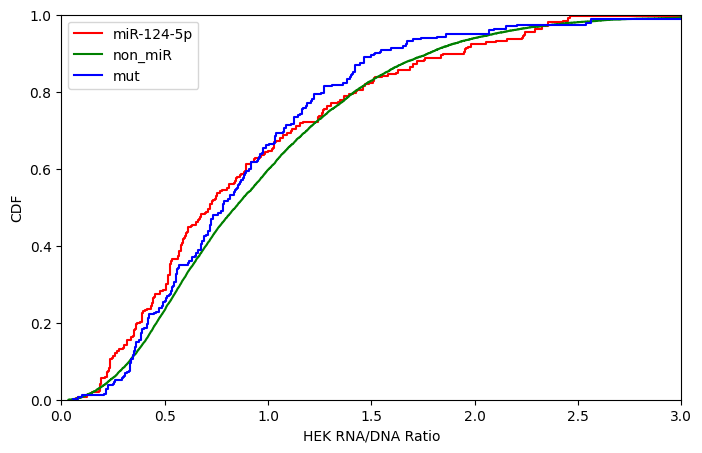

In [78]:
# draw ecdf plot

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Plotting ECDF
plt.figure(figsize=(8, 5))

# Empirical Cumulative Distribution Function plot
sns.ecdfplot(df_w_miR124['hek_rd'], label='miR-124-5p', linestyle='-', color='red')
sns.ecdfplot(df_wo_miR124['hek_rd'], label='non_miR', linestyle='-', color='green')
sns.ecdfplot(result['hek_rd'], label='mut', linestyle='-', color='blue')

plt.xlim(0,3)
plt.xlabel('HEK RNA/DNA Ratio')
plt.ylabel('CDF')
plt.grid(False)
plt.legend()
plt.show()

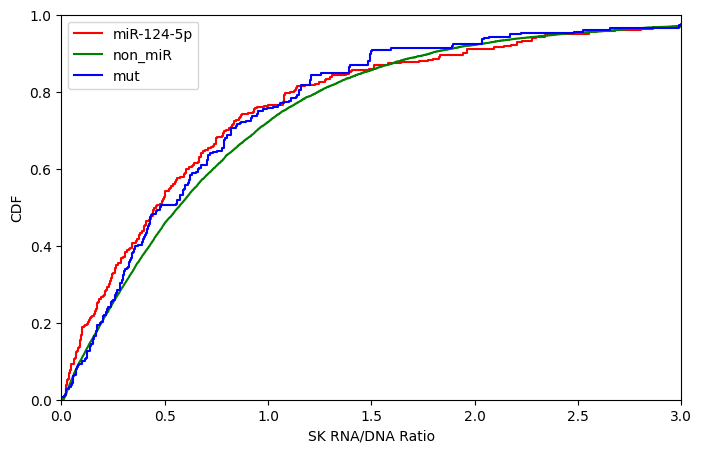

In [83]:
# draw ecdf plot

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Plotting ECDF
plt.figure(figsize=(8, 5))

# Empirical Cumulative Distribution Function plot
sns.ecdfplot(df_w_miR124['sk_rd'], label='miR-124-5p', linestyle='-', color='red')
sns.ecdfplot(df_wo_miR124['sk_rd'], label='non_miR', linestyle='-', color='green')
sns.ecdfplot(result['sk_rd'], label='mut', linestyle='-', color='blue')

plt.xlim(0,3)
plt.xlabel('SK RNA/DNA Ratio')
plt.ylabel('CDF')
plt.grid(False)
plt.legend()
plt.show()

In [81]:
# One-way ANOVA test for the three groups

from scipy.stats import f_oneway

F_statistic, p_value = f_oneway(df_w_miR124['hek_rd'], df_wo_miR124['hek_rd'], result['hek_rd'])
print("F-statistic:", F_statistic)
print("P-value:", p_value)


F-statistic: 3.6253746564662466
P-value: 0.026672061059546167


In [77]:
import pandas as pd
from scipy.stats import f_oneway
from statsmodels.stats.multicomp import pairwise_tukeyhsd

# Combine the groups into a single DataFrame
group1 = df_w_miR7['hek_rd']
group2 = df_wo_miR7['hek_rd']
group3 = result['hek_rd']

df = pd.DataFrame({
    'value': np.concatenate([group1, group2, group3]),
    'group': ['group1']*len(group1) + ['group2']*len(group2) + ['group3']*len(group3)
})

# Perform one-way ANOVA
F_statistic, p_value = f_oneway(group1, group2, group3)
print("One-way ANOVA")
print("F-statistic:", F_statistic)
print("P-value:", p_value)

# Check if we need to proceed with the post-hoc test
if p_value < 0.05:
    print("\nPerforming Tukey's HSD test because p-value < 0.05...")
    # Perform Tukey's HSD test
    tukey = pairwise_tukeyhsd(endog=df['value'],
                              groups=df['group'],
                              alpha=0.05)
    print(tukey)
else:
    print("\nNo need for post-hoc tests as there is no significant difference at the 0.05 level.")


One-way ANOVA
F-statistic: 3.4556996834417073
P-value: 0.031600907968577535

Performing Tukey's HSD test because p-value < 0.05...
Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj   lower  upper  reject
---------------------------------------------------
group1 group2   0.1251 0.2681 -0.0642 0.3144  False
group1 group3   0.0501  0.835 -0.1551 0.2553  False
group2 group3   -0.075  0.081  -0.157  0.007  False
---------------------------------------------------
